# San Diego Bike Collisions

Is it more or less likely to be injured in a bike-related accident if you are on a bike path or not? How would the results differ for injuries of different severity, by zip codes, and by the type of other party in the accident? In which parts of the city is it more likely to get into an alcohol-related accident? How can you explain that using additional statistics by zip codes, for example, by the number of alcohol-serving bars in the zip code? 

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis import features
from arcgis.features import use_proximity
from arcgis.geoenrichment import *
from arcgis.features.find_locations import find_existing_locations
from arcgis.features import FeatureLayer

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")

gis = GIS(username='dsl030_UCSDOnline')

Enter password: ········


## Load the data

In [2]:
# load data
collisions = pd.read_csv('data/Collisions.csv')
parties = pd.read_csv('data/Parties.csv')
victims = pd.read_csv('data/Victims.csv')
zips = gpd.read_file("data/ZIP_Code/ZIP_Code.shp")

# only keep wanted columns
collisions_cleaned = collisions.copy()[['CASE_ID', 'LONGITUDE', 'LATITUDE', 'POINT_X', 'POINT_Y']]
parties_cleaned = parties[['CASE_ID', 'PARTY_NUMBER', 'PARTY_TYPE', 'AT_FAULT', 'PARTY_SOBRIETY']]
victims_cleaned = victims[['CASE_ID', 'PARTY_NUMBER', 'VICTIM_ROLE', 'VICTIM_DEGREE_OF_INJURY']]

# clean collisions lat/lons
collisions_cleaned['POINT_X'] = collisions_cleaned['POINT_X'].fillna(collisions_cleaned['LONGITUDE'])
collisions_cleaned['POINT_Y'] = collisions_cleaned['POINT_Y'].fillna(collisions_cleaned['LATITUDE'])
collisions_cleaned = collisions_cleaned.drop(['LATITUDE', 'LONGITUDE'], axis=1)

## Joining party to collisions. 

In [3]:
merged = (
    pd.merge(collisions_cleaned, parties_cleaned, how='left', on='CASE_ID')
    .merge(victims_cleaned, how='left', on=['CASE_ID', 'PARTY_NUMBER'])
)
merged = merged.dropna(subset=['POINT_X', 'POINT_Y'])

# merged to gdf for spatial join
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(merged.POINT_X, merged.POINT_Y)]
gdf = gpd.GeoDataFrame(merged, crs=crs, geometry=geometry)
gdf.to_file('data/merged1/merged1.shp')

# spatial join
gdf = gpd.read_file('data/merged1/merged1.shp')
joined = gpd.sjoin(gdf, zips).drop(['POINT_X', 'POINT_Y'], axis=1)
# joined.to_file('data/joined/joined.shp')

## Clean spatial data as needed and create a point layer of collisions

In [4]:
# convert to spatial dataframe, clean
points_sdf = pd.DataFrame.spatial.from_featureclass('data/joined/joined.shp')
points_sdf = (
    points_sdf.replace(np.nan, '', regex=True)
    .drop(['index', 'index_righ', 'OBJECTID', 'COMMUNITY'], axis=1)
)

# publish point layer onto ArcGIS (ALREADY DONE)
# points_fl = points_sdf.spatial.to_featurelayer('points_DSL030')

## Define what you mean to be on a bike route and figure out, for each collision, whether it happened on a bike route or not. Summarize collisions of different types by zip codes.

In [5]:
# get bike routes, convert to sdf
routes = gis.content.get('086106add0a645ba864db08f45c795ea')
routes_sdf = pd.DataFrame.spatial.from_layer(routes.layers[0])
sd_routes_sdf = routes_sdf[routes_sdf.Jurisdicti == 'San Diego']

In [6]:
sd_routes_sdf.head()

,Jurisdicti,Max_Elev,OBJECTID,RD20FULL,ROUTE,Route_Clas,SHAPE,Shape_Leng,Shape__Length
1,San Diego,596.089307,2,BALTIMORE DR,2,Bike Lane,"{""paths"": [[[-13028270.07, 3867017.2263], [-13...",869.178045,316.024684
2,San Diego,297.958873,4,03RD AV,8,Other Suggested Routes,"{""paths"": [[[-13042440.2902, 3862416.5232], [-...",352.068928,128.078509
4,San Diego,294.060562,6,03RD AV,3,Bike Route,"{""paths"": [[[-13042435.8334, 3860948.3572], [-...",245.999750,89.480392
5,San Diego,57.458652,7,BEYER WY,3,Bike Route,"{""paths"": [[[-13031331.347, 3841152.3001], [-1...",262.427656,95.210672
8,San Diego,307.283652,10,ARRIBA ST,2,Bike Lane,"{""paths"": [[[-13049185.5785, 3876911.8856], [-...",799.113942,289.760722


In [7]:
### ALREADY PUT ONTO ARCGIS ### 
### URL: https://ucsdonline.maps.arcgis.com/home/item.html?id=c93f3b5105b14847a1a14de98ac057ae

# forbuff = merged[['CASE_ID', 'POINT_X', 'POINT_Y']].rename(columns={'POINT_X': 'longitude', 'POINT_Y': 'latitude'})
# forbuff.to_csv('data/forbuff.csv')

# # create point layer (collisions_item) and add to gis
# item_prop = {'title':'sd_collision_buff_DSL030'}
# csv_item = gis.content.add(item_properties=item_prop, data='data/forbuff.csv')
# collisions_item = csv_item.publish()

# create simple df for buffers
buff = gis.content.get('c93f3b5105b14847a1a14de98ac057ae').layers[0]
buff_collections = use_proximity.create_buffers(buff, distances=[100], units = 'Feet')
buff_sdf = buff_collections.query().sdf

In [34]:
# map to test if bike route/collision join worked
test = gis.map('San Diego', zoomlevel=15)

# join intersections
intersects = buff_sdf.spatial.join(sd_routes_sdf)

# # plot routes and points... it works!
sd_routes_sdf.spatial.plot(test)
intersects.spatial.plot(test)

True

In [35]:
test

MapView(layout=Layout(height='400px', width='100%'), zoom=15.0)

<img src="images/1.png">

In [9]:
# assign boolean values back to original sdf
inter_cases = list(intersects.CASE_ID)
points_sdf['ON_BIKEROUTE'] = points_sdf.CASE_ID.apply(lambda x: True if x in inter_cases else False).astype(int)

In [10]:
# find proportions of on-route collisions based on zipcode (only taking unique case_ids)
dropped_duplicates = points_sdf.drop_duplicates(subset='CASE_ID')
props = dropped_duplicates.groupby('ZIP')['ON_BIKEROUTE'].mean()
props.head(10)

ZIP
91911    0.000000
91942    1.000000
91950    0.000000
92014    0.692308
92020    0.000000
92037    0.698925
92067    1.000000
92093    0.916667
92101    0.705357
92102    0.623188
Name: ON_BIKEROUTE, dtype: float64

## Generate Maps

### Map 1: Alcohol Map
This is a map of whether or not alcohol was involved in the collision, as well as whether or not those collisions were on bike routes.
<br>
<br>
 - Blue Symbols: Alcohol was involved
<br>
 - Green Symbols: Alcohol wasn't involved
<br>
 - Circles: On bike route
<br>
 - Diamonds: Off bike route

In [11]:
############### MAP 1: ALCOHOL ###################

map1 = gis.map('San Diego', zoomlevel=11)

##### plot routes #####
sd_routes_sdf.spatial.plot(map1, 
                           symbol_type='simple',
                           cmap='Set1',
                           cstep=1)


##### split to yesalc vs noalc, turn into layers #####
yes_alc = points_sdf.copy()[points_sdf.PARTY_SOBR == 'A']
no_alc = points_sdf.copy()[points_sdf.PARTY_SOBR != 'A']

# url: https://ucsdonline.maps.arcgis.com/home/item.html?id=92efa2294d1d47b497ab9294b5c50fa9 
yes_alc_fl = gis.content.get('92efa2294d1d47b497ab9294b5c50fa9').layers[0]

# url: https://ucsdonline.maps.arcgis.com/home/item.html?id=e691f0c1b32246c081b593792516d098
no_alc_fl = gis.content.get('e691f0c1b32246c081b593792516d098').layers[0] 


##### render for yesalc #####
yes_render = {"renderer": "autocast", "type": "uniqueValue", "field1":"ON_BIKEROU"}

yes_render["uniqueValueInfos"] = [{"value": "1",
                                    "symbol": {"color":[0,0,128,128],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                    },
                                    "label": "1"
                                    },
                                    {"value": "0",
                                    "symbol": {"color":[0,0,128,128],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSDiamond","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                    },
                                    "label": "0"
                                    }]

##### render for noalc #####
no_render = {"renderer": "autocast", "type": "uniqueValue", "field1":"ON_BIKEROU"}

no_render["uniqueValueInfos"] = [{"value": "1",
                                    "symbol": {"color":[0,128,0,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                    },
                                    "label": "1"
                                    },
                                    {"value": "0",
                                    "symbol": {"color":[0,128,0,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSDiamond","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                    },
                                    "label": "0"
                                    }]

##### add point layers to map #####
map1.add_layer(yes_alc_fl,
              {"type": "FeatureLayer",
               "renderer": yes_render,
               "field_name":"ON_BIKEROU"})

map1.add_layer(no_alc_fl,
              {"type": "FeatureLayer",
               "renderer": no_render,
               "field_name":"ON_BIKEROU"})

In [12]:
map1

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

<img src="images/2.png">

### Map 2: At Fault because of Impairment Map
This is a map of whether or not the bicyclist was at fault because of impairment, as well as whether or not those collisions were on bike routes.
<br>
<br>
 - Red circles: Bicyclist was at fault and under the influence of alcohol
<br>
 - Yellow circles: Bicyclist was not at fault and under the influence of alcohol

In [13]:
############### MAP 2: FAULT BECAUSE OF IMPAIRMENT ###################

map2 = gis.map('San Diego', zoomlevel=11)

# plot routes and points
sd_routes_sdf.spatial.plot(map2, 
                           symbol_type='simple',
                           cmap='Set1',
                           cstep=1)

##### get impaired, turn into layer #####
impaired = points_sdf.copy()[points_sdf.PARTY_SOBR == 'B']

# url: https://ucsdonline.maps.arcgis.com/home/item.html?id=ab03150b87e94e648aaca35044dbe19f
impaired_fl = gis.content.get('ab03150b87e94e648aaca35044dbe19f').layers[0]


##### render for impaired #####
impaired_render = {"renderer": "autocast", "type": "uniqueValue", "field1":"AT_FAULT"}

impaired_render["uniqueValueInfos"] = [{"value": "Y",
                                    "symbol": {"color":[255,0,0,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                    }},
                                    {"value": "N",
                                    "symbol": {"color":[255,255,128,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                    }}]

##### add layers to map #####
map2.add_layer(impaired_fl,
              {"type": "FeatureLayer",
               "renderer": impaired_render,
               "field_name":"AT_FAULT"})

In [14]:
map2

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

<img src="images/3.png">

### Map 3: Type of Other Party Map 
This is a map of the type of parties involved in the collisions
<br>

Types of other party:
 - other (black)
 - no other party (red)
 - car in 2-party crash (teal)
 - pedestrian in 2-party crash (blue)
 - 2-way bike crash (green)
 - car and bike in 3-party crash (yellow)

In [15]:
# define the different types
def create_types(df):
    lis = list(df.PARTY_TYPE)
    
    if len(df) == 1:                    # no other party
        return 1
    elif len(df) == 2:
        if '1' in lis:                  # car in 2-party crash
            return 2
        elif '2' in lis:                # pedestrian in 2-party crash
            return 3
        elif lis.count('4') == 2:       # 2-way bike crash
            return 4
        else:                           # other 
            return -1
    elif len(df) == 3:
        if '1' in lis and '4' in lis:   # car and bike in 3-party crash
            return 5
        else: 
            return -1                   # other
    else:                               # other
        return -1
    
diff_types = points_sdf.groupby('CASE_ID').apply(create_types)
case_id_shapes = points_sdf.groupby('CASE_ID').apply(lambda x: x.SHAPE.iloc[0])
types_sdf = pd.DataFrame({'TYPE': diff_types, 'SHAPE': case_id_shapes})

In [16]:
# define renders
m3_render = {"renderer": "autocast", "type": "uniqueValue", "field1":"TYPE"}

m3_render["uniqueValueInfos"] = [{"value": "-1",
                                  "symbol": {"color":[0,0,0,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                  }},
                                 {"value": "1",
                                  "symbol": {"color":[255,40,40,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                  }},
                                 {"value": "2",
                                  "symbol": {"color":[40,239,212,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                  }},
                                 {"value": "3",
                                  "symbol": {"color":[40,40,239,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                  }},
                                 {"value": "4",
                                  "symbol": {"color":[60,239,40,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                  }},
                                 {"value": "5",
                                  "symbol": {"color":[212,230,40,200],"size":10,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle","outline":{"color":[0,0,128,255],"width":1,"type":"esriSLS","style":"esriSLSSolid"}
                                  }}]

In [17]:
############### MAP 3: TYPE OF OTHER PARTY ###################

map3 = gis.map('San Diego', zoomlevel=11)

# plot routes and points
sd_routes_sdf.spatial.plot(map3, 
                           symbol_type='simple',
                           cmap='Set1',
                           cstep=1)

##### get types, turn into layer #####
# url: https://ucsdonline.maps.arcgis.com/home/item.html?id=48d582e9f2d04016a5eda4b7fe122d9c
types_fl = gis.content.get('48d582e9f2d04016a5eda4b7fe122d9c').layers[0]


##### plot points #####
map3.add_layer(types_fl,
              {"type": "FeatureLayer",
               "renderer": m3_render,
               "field_name":"AT_FAULT"})

In [18]:
# legend:
# -1. other (black)
#  1. no other party (red)
#  2. car in 2-party crash (teal)
#  3. pedestrian in 2-party crash (blue)
#  4. 2-way bike crash (green)
#  5. car and bike in 3-party crash (yellow)

diff_types.value_counts().sort_index()

-1     111
 1     428
 2    1259
 3      32
 4      27
 5      74
dtype: int64

In [19]:
map3

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

<img src="images/4.png">

### Map 4: Zip Codes and Alcohol Selling Stores
Map by zip codes showing the alcohol-related bicycle accidents and number of alcohol stores in each zip code.
<br>
 - The darker the zip code, the more alcohol selling stores
 - Blue Symbols: Alcohol was involved
 - Green Symbols: Alcohol wasn't involved
 - Circles: On bike route
 - Diamonds: Off bike route

In [20]:
# Grab sd zipcodes 
unique_zips = list(points_sdf.ZIP.unique())
codes_layer = gis.content.get('81cf0db99f754a0ebc6f5ddaefd7bcad').layers[0]
codes_sdf = pd.DataFrame.spatial.from_layer(codes_layer)
sdcodes_sdf = codes_sdf[codes_sdf.ZIP.isin(unique_zips) | (codes_sdf.COMMUNITY == 'San Diego')]

In [21]:
sdcodes_sdf_1 = codes_sdf[codes_sdf.ZIP.isin(unique_zips)]
sdcodes_sdf_1.head()

,COMMUNITY,FID,OBJECTID,SHAPE,SHAPE_AREA,SHAPE_LEN,ZIP
0,San Diego,1,8,"{""rings"": [[[-13035996.9072395, 3865739.514441...",9.116940e+07,56719.411038,92116
1,San Diego,2,9,"{""rings"": [[[-13035678.0501648, 3867370.750019...",1.391020e+08,87998.181001,92108
2,San Diego,3,10,"{""rings"": [[[-13037962.0372208, 3874310.039323...",2.250658e+08,71051.924417,92123
5,La Jolla,6,13,"{""rings"": [[[-13051529.4599386, 3880716.507449...",3.777415e+07,37877.192885,92093
6,La Jolla,7,14,"{""rings"": [[[-13048208.9903172, 3878401.124024...",2.633243e+08,96029.877710,92037


In [22]:
# deal with arcgis shenanigans
# sdcodes_layer = find_existing_locations(input_layers=[{'url': codes_layer.url}],
#                                          expressions=[{"operator":"","layer":0,"where":"COMMUNITY = 'San Diego'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'La Jolla'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'Del Mar'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'Chula Vista'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'National City'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'La Mesa'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'Coronado'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'El Cajon'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'Rancho Santa Fe'"},
#                                                       {"operator":"or","layer":0,"where":"COMMUNITY = 'San Ysidro'"}],
#                                          output_name='sdcodes_DSL030')

# url: https://ucsdonline.maps.arcgis.com/home/item.html?id=be820ef242d540d592a8df6d81b1699c
sdcodes_layer = gis.content.get('be820ef242d540d592a8df6d81b1699c').layers[0]

In [23]:
# feature layer codes
codes_sdf = sdcodes_layer.query().sdf
codes_sdf.head()

,COMMUNITY,OBJECTID,OBJECTID_1,SHAPE,ZIP,ZIPALC
0,San Diego,8,1,"{""rings"": [[[-13035996.9072, 3865739.5144], [-...",92116,12
1,San Diego,9,2,"{""rings"": [[[-13035678.0502, 3867370.75], [-13...",92108,3
2,San Diego,10,3,"{""rings"": [[[-13037962.0372, 3874310.0393], [-...",92123,5
3,La Jolla,13,4,"{""rings"": [[[-13051529.4599, 3880716.5074], [-...",92093,0
4,La Jolla,14,5,"{""rings"": [[[-13048208.9903, 3878401.124], [-1...",92037,3


In [24]:
# find businesses with alcohol
buis = pd.read_csv('data/sd_businesses_active_since08_datasd.csv')
ca_buis = buis[buis.state == 'CA']
stores_with_alc = ['BEER, WINE & LIQUOR STORES', 'TOBACCO STORES', 'CONVENIENCE STORES']
alc = ca_buis.copy()[ca_buis.naics_description.isin(stores_with_alc)]
alc['zip'] = alc['zip'].str[:5].astype(int)

In [25]:
# number of stores in each zip code
alc_in_sd = alc[alc.zip.isin(list(sdcodes_sdf.ZIP))]
alc_counts = pd.DataFrame(alc_in_sd.zip.value_counts()).rename(columns={'zip':'zipcounts'}).reset_index()
alc_counts.head()

,index,zipcounts
0,92101,27
1,92115,26
2,92109,17
3,92116,12
4,92104,12


In [26]:
# find alc counts, manually add data to arcgis online
merged_alc = (
    pd.DataFrame(codes_sdf.ZIP, columns=['ZIP'])
    .merge(alc_counts, how='left', left_on='ZIP', right_on='index')
    .fillna(0)
    .astype(int)
)

In [27]:
############### MAP 4: ZIP CODES AND ALCOHOL ###################

map4 = gis.map('San Diego', zoomlevel=11)

##### plot zipcodes #####

map4.add_layer(sdcodes_layer,
              {"type":"FeatureLayer",
               "renderer":"ClassedColorRenderer",
               "field_name":"ZIPALC",
               "opacity":0.7
              })

##### add point layers to map using renders from map1 #####
map4.add_layer(yes_alc_fl,
              {"type": "FeatureLayer",
               "renderer": yes_render,
               "field_name":"ON_BIKEROU"})

map4.add_layer(no_alc_fl,
              {"type": "FeatureLayer",
               "renderer": no_render,
               "field_name":"ON_BIKEROU"})

In [28]:
map4

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

<img src="images/5.png">

## Analysis and Responses

### Maps Discussion
Map 1: 
<br>
Just glancing at the map, it seems like there are a decent amount more blue points than green points, leading me to think that the majority of bike collisions occur when alcohol is involved in an accident. This makes sense; impaired people are ostensibly more likely to get into an accident than non-impaired.
<br>
Map 2:
<br>
Looking at the map, there are definitely a lot more red points than yellow points. Again, this makes sense; it is very likely that those alcoholically impaired were the ones that were at fault when it comes to collisions.
<br>
Map 3:
<br>
I found this map interesting. The largest amount of collisions by far were two-party collisions between a car and a bike. I didn't think this would be the case, because looking at the map, it seems like most collisions were on bike paths where cars shouldn't be. The second largest amount of collisions was also interesting: no other party collisions. I suspect this is due to people either learning to bike and falling off or some issues with the terrain. 
<br>
Map 4:
<br>
This map makes a lot of sense to me. It is obvious that zip codes with crowds of collisions were in darker shaded zip codes (where there are more alcohol selling stores). This observations goes along with the first two observations in the first two maps: alcohol plays a major role in bike collisions in San Diego.

### Analysis Discussion

In [30]:
# Is it more or less likely to be injured in a bike-related accident if you are on a bike path or not?

# prop collisions
print('Proportion of collisions that occured on paths: ' + str(points_sdf.ON_BIKEROUTE.mean()))
print('')

# prop victim degree of injury
injury_sdf = points_sdf.copy()
injury_sdf['VICTIM_DEG'] = injury_sdf['VICTIM_DEG'].replace({'': 0})
injury_sdf['INJURED'] = injury_sdf['VICTIM_DEG'].apply(lambda x: x!=0)
injury_sdf['ON_BIKEROUTE'] = injury_sdf['ON_BIKEROUTE'].astype(bool)
print('Proportion of victims injured:')
display(injury_sdf.groupby('ON_BIKEROUTE')['INJURED'].mean())

Proportion of collisions that occured on paths: 0.6603404967903991

Proportion of victims injured:


ON_BIKEROUTE
False    0.557108
True     0.556636
Name: INJURED, dtype: float64

Total Variation distances:
injuries = 0.061830645466515025
zips = 0.2308877186088553
types = 0.03989402370503804


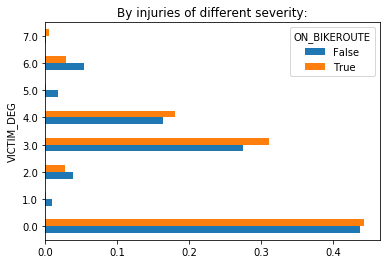

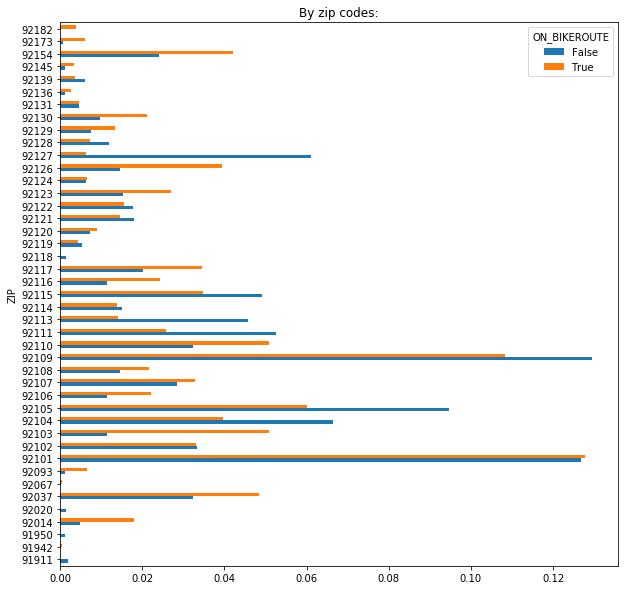

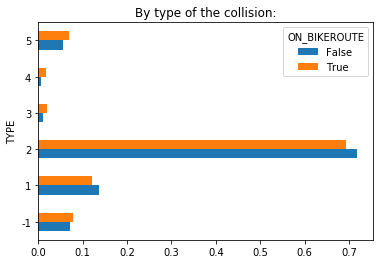

In [31]:
# How would the results differ for injuries of different severity, by zip codes, and by the type of 
# the collision?

# create pivot tables for proportions
injuries_piv = (
    injury_sdf
    .pivot_table(index='VICTIM_DEG', 
                 columns='ON_BIKEROUTE', 
                 values='CASE_ID', 
                 aggfunc='sum')
    .apply(lambda x: x/x.sum())
)
zips_piv = (
    injury_sdf
    .pivot_table(index='ZIP', 
                 columns='ON_BIKEROUTE', 
                 values='CASE_ID', 
                 aggfunc='sum')
    .apply(lambda x: x/x.sum())
    .fillna(0)
)
types = injury_sdf.merge(diff_types.reset_index(), how='inner', on='CASE_ID').rename(columns={0:'TYPE'})
types_piv = (
    types
    .pivot_table(index='TYPE', 
                 columns='ON_BIKEROUTE', 
                 values='CASE_ID', 
                 aggfunc='sum')
    .apply(lambda x: x/x.sum())
    .fillna(0)
)

# calculate tvds:
def tvd(df):
    return sum(abs(df[True] - df[False])) / 2
print('Total Variation distances:')
print('injuries = ' + str(tvd(injuries_piv)))
print('zips = ' + str(tvd(zips_piv)))
print('types = ' + str(tvd(types_piv)))

# plot the pivot tables
injuries_piv.plot.barh(title='By injuries of different severity:')
zips_piv.plot.barh(figsize=(10,10), title='By zip codes:')
types_piv.plot.barh(title='By type of the collision:')

R-score = 0.7868828861850209


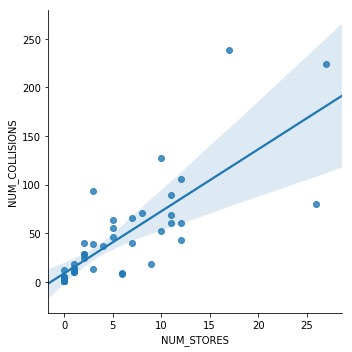

In [32]:
# In which parts of the city is it more likely to get into an alcohol-related accident? How can you 
# explain that using additional statistics by zip codes, for example, by the number of alcohol selling 
# stores in the zip code?

# create df with number of collisions in each zipcode, merge with number of alcohol selling stores in zips
zips_and_alc = (
    pd.DataFrame(points_sdf.groupby('ZIP')['CASE_ID'].nunique())
    .reset_index()
    .merge(alc_counts, how='left', left_on='ZIP', right_on='index')
    .drop('index', axis=1)
    .rename(columns={'CASE_ID': 'NUM_COLLISIONS', 'zipcounts':'NUM_STORES'})
    .fillna(0)
)
reg = linregress(x=zips_and_alc['NUM_STORES'], y=zips_and_alc['NUM_COLLISIONS'])
print('R-score = ' + str(reg.rvalue))
sns.lmplot(x='NUM_STORES',y='NUM_COLLISIONS',data=zips_and_alc) 

1. Is it more or less likely to be injured in a bike-related accident if you are on a bike path or not?
 - In the most general case, it seems that it isn't particularly more or less likely to be injured in a bike-related accident if you are on a bike path or not. In both cases, about 55% of collisions on/off bike paths resulted in injuries.
<br>
2. How would the results differ for injuries of different severity, by zip codes, and by the type of accident?
 - Again, for the most part, it seems that there isn't a clear identifier for how likely someone is to get injured in a bike-related accident/collision. I tested this claim on three variables: injuries of different severity, by zip codes, and type of accident. First, I created a pivot table each for these variables, indexed by the variables with columns True and False for whether or not the collision was on a bikepath, using this information to plot distributions across these variables. Specifically in the first and third cases, the total variation distances (tvds) between these distributions were very small, less than 0.07. The zip case had a slightly larger tvd, around 0.23, which is still pretty small. Thus, I unsatisfyingly conclude that neither of these variables can give us a good answer to what causes injury on bike paths. 
<br>
3. In which parts of the city is it more likely to get into an alcohol-related accident? How can you explain that using additional statistics by zip codes, for example, by the number of alcohol selling stores in the zip code?
 - This section was much more satisfying. As I predicted when I visualized Map 4, zip codes that had more alcohol selling stores had more bike collisions. When I plotted a regression line, I got an rscore of about 0.79, showing a rather strong correlation between these two variables!

## Find additional interesting information by joining the victims table

In [33]:
# joined victims data
ec_df = points_sdf.copy()
ec_df['VICTIM_DEG'] = ec_df['VICTIM_DEG'].replace({'': 0})

# Question: are victim degrees of injury likely to be higher if the party at fault was alcoholically impaired?
fault_alc = ec_df[(ec_df.AT_FAULT == 'Y') & (ec_df.PARTY_SOBR == 'B')]
fault_no_alc = ec_df[(ec_df.AT_FAULT == 'Y') & (ec_df.PARTY_SOBR != 'B')]
print('fault with alcohol: ' + str(fault_alc.VICTIM_DEG.mean()))
print('fault with no alcohol: ' + str(fault_no_alc.VICTIM_DEG.mean()))

fault with alcohol: 2.5
fault with no alcohol: 1.9398496240601504


The average victim degree of injury seems to be higher if the party at fault was alcoholically impaired, but only slightly. It would take more analysis to see if that number was just by chance.